In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', 'ansr-models', MODEL, CHECKPOINT),
    beam_width=32,
    n_restarts=8,
    verbose=True,
    numeric_head=False
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


# 1D

In [ ]:
positive_demo_expressions = [
    ('x**2', None, (-5, 5)),
    ('sin(x)', None, (-5, 5)),
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x1) / x1))', None, (-10, 10)),
]

negative_demo_expressions = [
    ('-x + log(x + x**4)', None, (1, 5)),
    ('0.1 * ((1.1 / x)**(12) - (1.2 / x)**6)', (0.1, 1.1, 1.2), (0.8, 2.5)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85)))', (5.3, 1, 0.72, 2.85), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x)', (5.3, 1, 0.72, 2.85, 1.5), (-10, 10)),
]

positive_results = []
negative_results = []

for results, demo_expressions in zip([positive_results, negative_results], [positive_demo_expressions, negative_demo_expressions]):
    for expression, constants, xlim in tqdm(demo_expressions):
        prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
        prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
        prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
        code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
        code = codify(code_string, nsr.expression_space.variables + constants_names)

        if constants is None:
            demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
        else:
            demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

        x = np.random.uniform(*xlim, 100)

        y = demo_function(x)

        if isinstance(y, float):
            y = np.full_like(x, y)

        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

        x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000)
        x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)

        try:
            nsr.fit(x_tensor, y_tensor, converge_error='raise')
        except ConvergenceError as e:
            print('Failed to converge for:', code_string)
            results.append(None)
            continue

        y_pred = [[nsr.predict(x_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]
        y_pred_linspace = [[nsr.predict(x_linspace_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]

        results.append({
            '_results': nsr._results,
            'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32))) if len(y_pred[j]) > 0 else np.nan) for j in range(len(y_pred))],
            'log_p': [np.log10(np.exp(nsr._results[j][1]["log_prob"])) for j in range(len(nsr._results))],
            'expression_pred_transformed': [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))],
            'expression_pred_transformed_infix': [nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**') for expression_pred_transformed in [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))]],
            'y_pred': y_pred,
            'y_pred_linspace': y_pred_linspace,
            'x': x,
            'y': y,
            'x_linspace': x_linspace,
            'x_tensor': x_tensor,
            'y_tensor': y_tensor,
            'x_linspace_tensor': x_linspace_tensor,
            'demo_function': demo_function,
            'code': code,
            'code_string': code_string,
            'prefix_expression': prefix_expression,
            'prefix_expression_w_num': prefix_expression_w_num,
            'prefix_expression_w_constants': prefix_expression_w_constants,
            'constants_names': constants_names,
            'constants': constants,
            'xlim': xlim,
        })

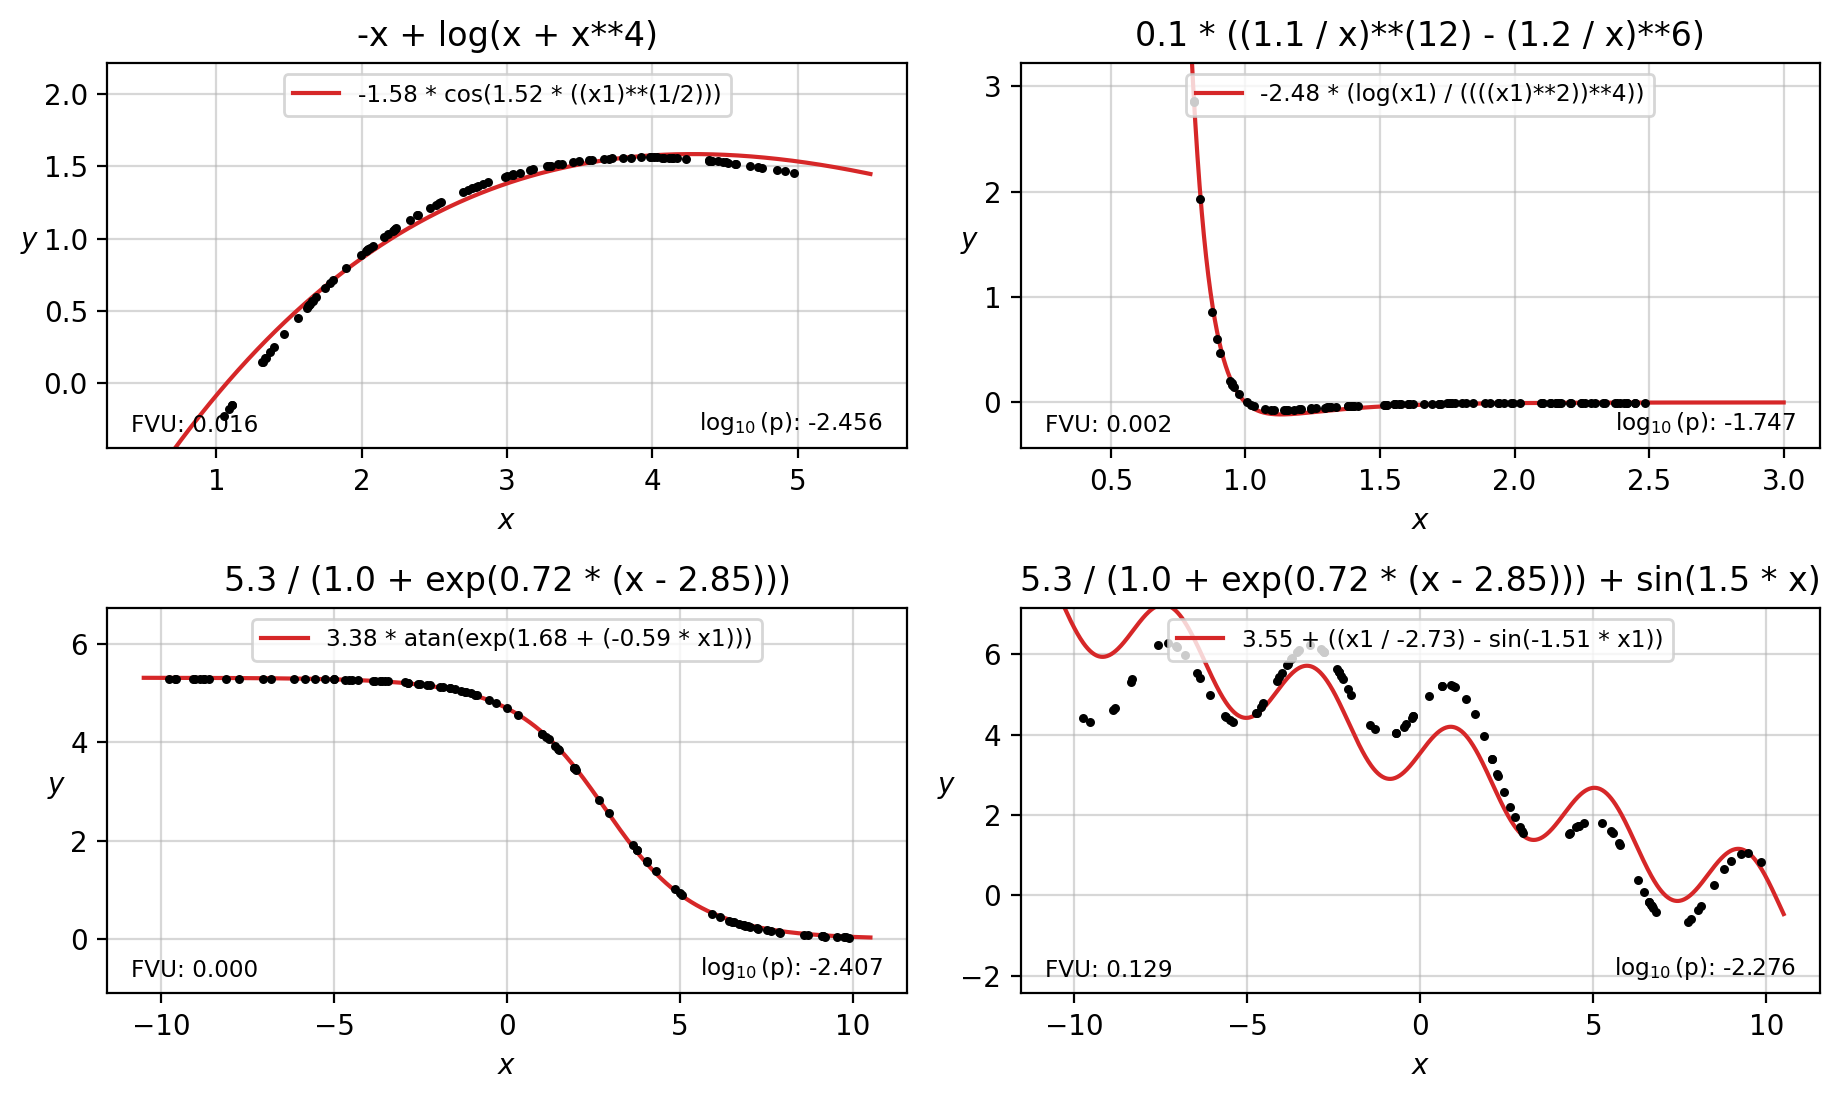

In [19]:
plot_fit = True
# results = positive_results
# demo_expressions = positive_demo_expressions
results = negative_results
demo_expressions = negative_demo_expressions

COLS = 2
ROWS = np.ceil(len(results) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.1 * 1.5, ROWS * 2.8 * 1.0), dpi=200)

for i, (ax, result) in enumerate(zip(axes.flat, results)):

    if plot_fit:
        ax.plot(result['x_linspace'], result['y_pred_linspace'][0][0], color='tab:red', label=result['expression_pred_transformed_infix'][0])
    
    # if i >= (ROWS - 1) * COLS:
    ax.set_xlabel('$x$')
    # if i % COLS == 0:
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

    ax.scatter(result['x'], result['y'], color='k', s=5, zorder=4)
    ax.grid(alpha=0.5)

    ax.set_title(demo_expressions[i][0])

    ylim_span = ax.get_ylim()[1] - ax.get_ylim()[0]
    new_ylim = ax.get_ylim()[0] - ylim_span * 0.15, ax.get_ylim()[1] + ylim_span * 0.2

    if ylim_span < 1e-3:
        new_ylim = ax.get_ylim()[0] - 0.1, ax.get_ylim()[1] + 0.2
    else:
        padding = 0.125 * (max(result['y']) - min(result['y']))
    
        if ax.get_ylim()[0] < min(result['y']) - padding:
            new_ylim = min(result['y']) - padding, new_ylim[1]

        if ax.get_ylim()[1] > max(result['y']) + padding:
            new_ylim = new_ylim[0], max(result['y']) + padding

    ax.set_ylim(new_ylim)

    if plot_fit:
        ax.legend(loc='upper center', fontsize='small')

    if plot_fit:
        ax.annotate(f'FVU: {result["fvu"][0]:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
        ax.annotate(f'$\\log_{{10}}$(p): {result["log_p"][0]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

for ax in axes.flat[len(results):]:
    ax.axis('off')

fig.tight_layout()

# 2D

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', 'ansr-models', MODEL, CHECKPOINT),
    beam_width=32,
    n_restarts=8,
    verbose=True,
    numeric_head=False
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [17]:
RESOLUTION = 512

In [18]:
positive_demo_expressions = [
    ('x1**2 + x_2', None, (-5, 5)),
    ('sin(x1 * x2)', None, (-5, 5)),
    ('x1**2 + 2*x1*x2 + x2**2', (2,), (1, 5)),
    ('x1 * exp(- x2**2)', None, (-5, 5)),
    ('x1**3 + 2*x2**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x1 - x2)**2 / 4.3)', (4.3,), (-10, 10)),
    ('exp(- (x1 - 1.4)**2 / (x2 + 1))', (1.4, 1.0), (1, 10)),
    ('cos(3.3 * x1 + x2) * exp(-x1 * 0.5)', (3.3, 0.5,), (0, 5)),
    ('x2 * sin(0.5 * x1**2)', (0.5,), (-5, 5)),
    ('x1 + 3.2 * exp(-1.8 * x1**2) * sin(x2)', (3.2, -1.8,), (-5, 5)),
    ('0.4 * x^**2 + 3.5 * sin(x1 * x2)', (0.4, 3.5), (-5, 5)),
    ('x1 * x2 + exp(-2 * sin(x1))', (-2,), (-5, 5)),
]

negative_demo_expressions = [
    ('sin(1.4 * x1) * exp(cos(x2 - 5.4))', (1.4, 5.4), (-10, 10)),
]

positive_results = []
negative_results = []

for results, demo_expressions in zip([positive_results, negative_results], [positive_demo_expressions, negative_demo_expressions]):
    for expression, constants, xlim in tqdm(demo_expressions):
        prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
        prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
        prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
        code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
        code = codify(code_string, nsr.expression_space.variables + constants_names)

        if constants is None:
            demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(*x.T, 0)
        else:
            demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(*x.T, 0, *constants)

        x = np.random.uniform(*xlim, (100, 2)).astype(np.float32)

        y = demo_function(x)

        if isinstance(y, float):
            y = np.full_like(x, y)

        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

        x_linspace = np.linspace(xlim[0] - 5, xlim[1] + 5, RESOLUTION)

        x_mesh = np.meshgrid(x_linspace, x_linspace)
        x_points = np.stack([x_mesh[0].ravel(), x_mesh[1].ravel()], axis=-1)
        x_mesh_tensor = torch.tensor(x_points, dtype=torch.float32).to(device)

        y_mesh = demo_function(x_points)

        try:
            nsr.fit(x_tensor, y_tensor, converge_error='raise')
        except ConvergenceError as e:
            print('Failed to converge for:', code_string)
            results.append(None)
            continue

        y_pred = [[nsr.predict(x_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]
        y_pred_mesh = [[nsr.predict(x_mesh_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]

        results.append({
            '_results': nsr._results,
            'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32))) if len(y_pred[j]) > 0 else np.nan) for j in range(len(y_pred))],
            'log_p': [np.log10(np.exp(nsr._results[j][1]["log_prob"])) for j in range(len(nsr._results))],
            'expression_pred_transformed': [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))],
            'expression_pred_transformed_infix': [nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**') for expression_pred_transformed in [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))]],
            'y_pred': y_pred,
            'y_pred_mesh': y_pred_mesh,
            'x': x,
            'y': y,
            'x_mesh': x_points,
            'x_tensor': x_tensor,
            'y_tensor': y_tensor,
            'y_mesh': y_mesh,
            'x_mesh_tensor': x_mesh_tensor,
            'demo_function': demo_function,
            'code': code,
            'code_string': code_string,
            'prefix_expression': prefix_expression,
            'prefix_expression_w_num': prefix_expression_w_num,
            'prefix_expression_w_constants': prefix_expression_w_constants,
            'constants_names': constants_names,
            'constants': constants,
            'xlim': xlim,
        })

 42%|████▏     | 5/12 [00:09<00:12,  1.80s/it]<lambdifygenerated-1739966285527786419:1: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_5856/2406427158.py:66: RuntimeWarning: overflow encountered in square
  'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32))) if len(y_pred[j]) > 0 else np.nan) for j in range(len(y_pred))],
 50%|█████     | 6/12 [00:10<00:11,  1.86s/it]<lambdifygenerated-1739966287649218267:1: RuntimeWarning: overflow encountered in exp
<lambdifygenerated-1739966287632291763:1: RuntimeWarning: invalid value encountered in sin
 75%|███████▌  | 9/12 [00:17<00:05,  1.98s/it]<lambdifygenerated-1739966294210109710:1: RuntimeWarning: overflow encountered in exp
<lambdifygenerated-1739966294203442163:1: RuntimeWarning: invalid value encountered in sin
/tmp/ipykernel_5856/2406427158.py:66: RuntimeWarning: overflow encountered in square
  'fvu': [(np.nanmean((y_pred[j][0][:, 0].num

/tmp/ipykernel_5856/3162793924.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_err = (y_pred_mesh - y_mesh) / y_mesh
/tmp/ipykernel_5856/3162793924.py:61: RuntimeWarning: invalid value encountered in divide
  y_err = (y_pred_mesh - y_mesh) / y_mesh


/tmp/ipykernel_5856/3162793924.py:25: RuntimeWarning: overflow encountered in cast
  y_mesh = np.squeeze(result['y_mesh'].reshape(RESOLUTION, RESOLUTION, 1)).astype(np.float32)
/tmp/ipykernel_5856/3162793924.py:61: RuntimeWarning: invalid value encountered in subtract
  y_err = (y_pred_mesh - y_mesh) / y_mesh


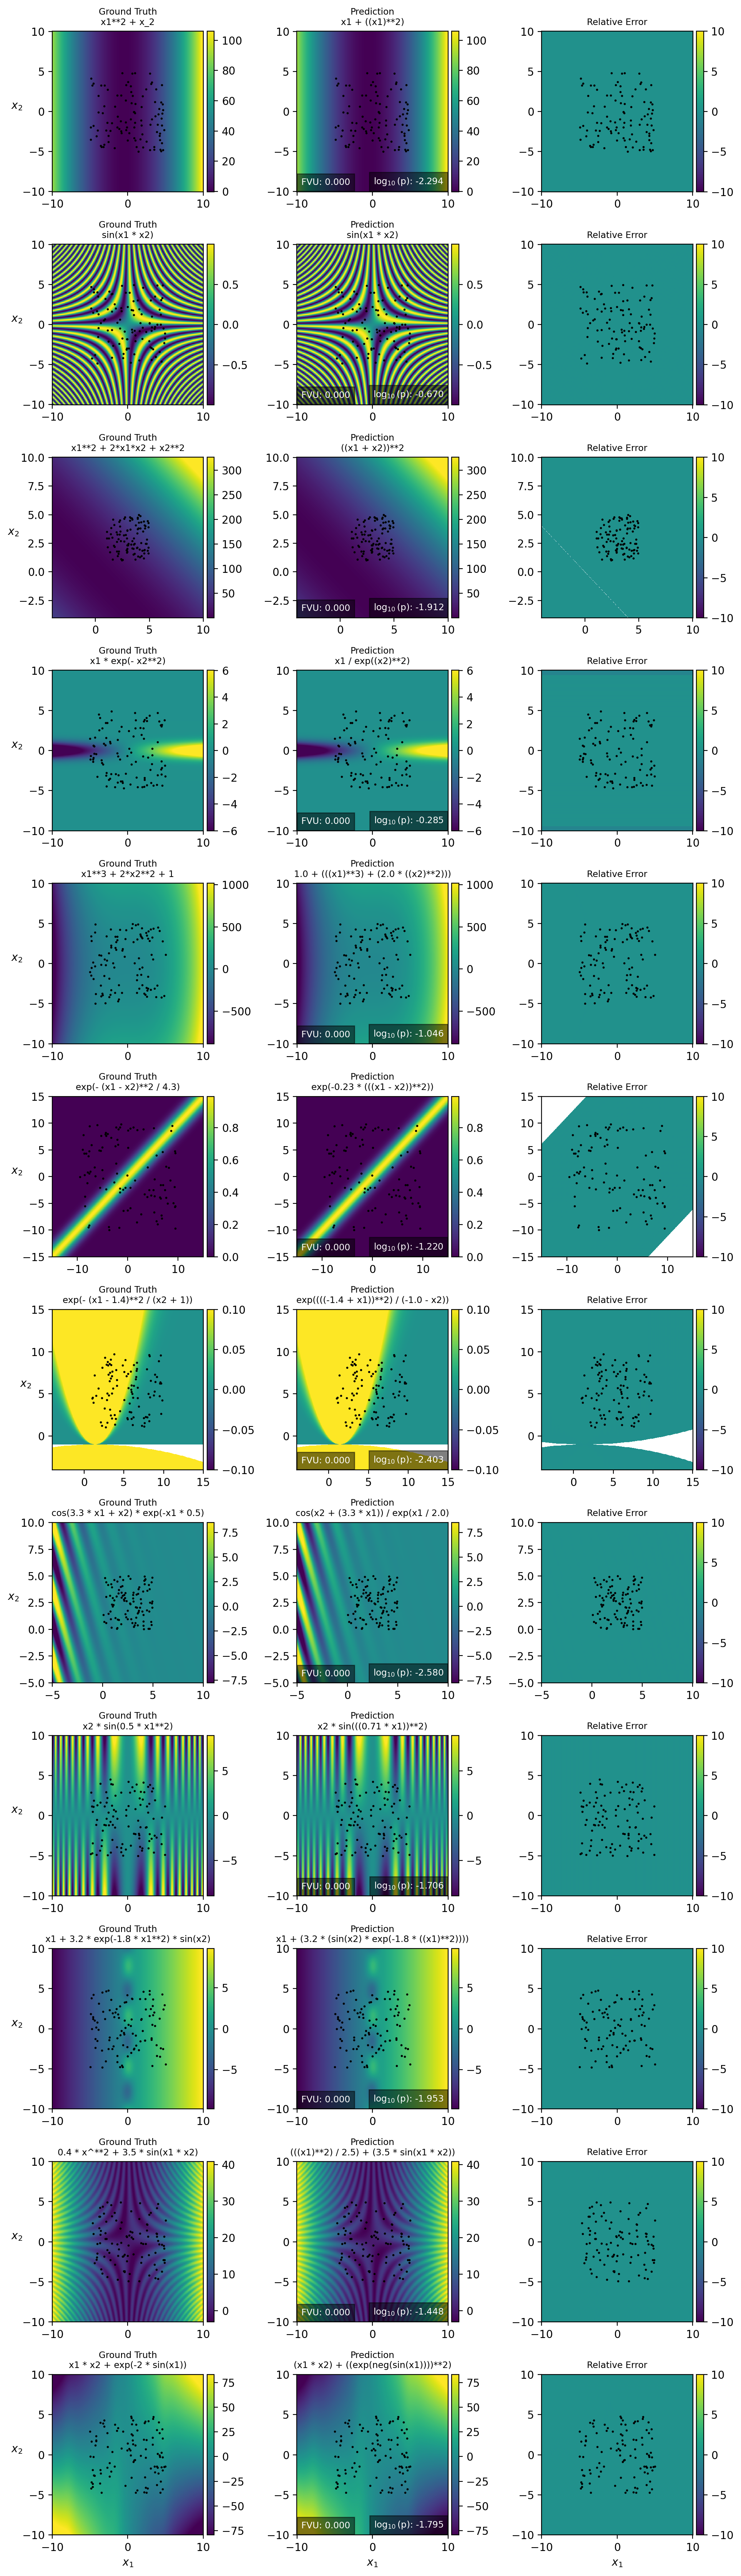

In [25]:
results = positive_results
demo_expressions = positive_demo_expressions
# results = negative_results
# demo_expressions = negative_demo_expressions

COLS = 1
ROWS = np.ceil(len(results) / COLS).astype(int)

s = 1.0

fig, axes = plt.subplots(ROWS, COLS * 3, figsize=(COLS * 3 * 3.1 * s, ROWS * 2.8 * s), dpi=200)
axes = np.atleast_2d(axes)

meshes_gt = []
meshes_pred = []
meshes_err = []

for r in range(ROWS):
    for c in range(COLS):
        i = r * COLS + c
        if i >= len(results):
            break
        result = results[i]
        # Reshape and prepare data
        y_mesh = np.squeeze(result['y_mesh'].reshape(RESOLUTION, RESOLUTION, 1)).astype(np.float32)
        vmin = np.nanpercentile(y_mesh, 1)
        vmax = np.nanpercentile(y_mesh, 99)
        
        # --- Ground Truth ---
        ax_gt = axes[r, 0 + 3 * c]
        mesh_gt = ax_gt.pcolormesh(
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 0],
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 1],
            y_mesh,
            vmin=vmin,
            vmax=vmax
        )
        meshes_gt.append(mesh_gt)
        ax_gt.set_title("Ground Truth\n" + demo_expressions[i][0], fontsize='small')
        
        # --- Prediction ---
        y_pred_mesh = np.squeeze(result['y_pred_mesh'][0][0][:, 0].reshape(RESOLUTION, RESOLUTION, 1))
        ax_pred = axes[r, 1 + 3 * c]
        mesh_pred = ax_pred.pcolormesh(
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 0],
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 1],
            y_pred_mesh,
            vmin=vmin,
            vmax=vmax
        )
        meshes_pred.append(mesh_pred)
        ax_pred.set_title("Prediction\n" + result['expression_pred_transformed_infix'][0], fontsize='small')
        ax_pred.annotate(f'FVU: {result["fvu"][0]:.3f}', xy=(0.03, 0.03),
                         xycoords='axes fraction', ha='left', va='bottom', fontsize='small',
                         color='w', zorder=5, bbox=dict(facecolor='k', alpha=0.5, edgecolor='black'))
        ax_pred.annotate(f'$\\log_{{10}}$(p): {result["log_p"][0]:.3f}', xy=(0.97, 0.03),
                         xycoords='axes fraction', ha='right', va='bottom', fontsize='small',
                         color='w', zorder=5, bbox=dict(facecolor='k', alpha=0.5, edgecolor='black'))
        
        # --- Relative Error ---
        y_err = (y_pred_mesh - y_mesh) / y_mesh
        ax_err = axes[r, 2 + 3 * c]
        mesh_err = ax_err.pcolormesh(
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 0],
            result['x_mesh'].reshape(RESOLUTION, RESOLUTION, 2)[:, :, 1],
            y_err, vmin=-10, vmax=10
        )
        meshes_err.append(mesh_err)
        ax_err.set_title("Relative Error", fontsize='small')
        
        # --- Mark data points ---
        for ax in [ax_gt, ax_pred, ax_err]:
            ax.scatter(result['x'][:, 0], result['x'][:, 1], color='k', s=1, zorder=4)
        
# --- Axis labels ---
for ax in axes[:, 0]:
    ax.set_ylabel('$x_2$', rotation=0, labelpad=5)
for ax in axes[-1, :]:
    ax.set_xlabel('$x_1$')

fig.tight_layout(h_pad=1, w_pad=5)

for r in range(ROWS):
    for c in range(COLS):
        i = r * COLS + c
        if i >= len(results):
            break
        result = results[i]

        for k, mesh in enumerate([meshes_gt, meshes_pred, meshes_err]):
            ax = axes[r, k + 3 * c]
            pos = ax.get_position()

            cbar_left = pos.x1 + 0.005  # a small offset
            cbar_width = 0.01
            cbar_height = pos.y1 - pos.y0
            cax = fig.add_axes([cbar_left, pos.y0, cbar_width, cbar_height])
            fig.colorbar(mesh[i], cax=cax)